In [1]:
##############
#K. David Roell CFPB 7/12/16
#expands data selection for quality edits to include context for developing statistical approaches
#will attemtp to segment mortgage market participants by loan activity by:
#volume/count of lending, income of applicants, securitization, property type and other factors
##############

import json
import os
import pandas as pd
import psycopg2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
get_ipython().magic(u'matplotlib inline')
matplotlib.style.use('ggplot')
#from macro_sql import Q076 
with open('quality_sql.json') as f: #FIXME change to quality_sql.json and refactor the rest of code
    edit_sql = json.load(f)
    
#parameter format for local use #consider changing hmdamaster to roellk if db changes cause a fail
params = {
'dbname':'hmdamaster',
'user':'roellk',
'password':'',
'host':'localhost',
}

try:
    conn = psycopg2.connect(**params)
    cur = conn.cursor()
    print("i'm connected")

except psycopg2.Error as e: #if database connection results in an error print the following
    print("I am unable to connect to the database: ", e)

i'm connected


In [17]:
#get distributions of values for fields
def field_dist_geo(field1=None, field2=None, table=None, geo_level=None, prop_type='1', loan_purp='1', loan_type='1'):
    """generates a sql statement used to pull values and associated counts for the listed variable subject to listed filters"""
    #FIXME use a list instead of prop_type, loan_purp, loan_type
    if geo_level == 'MSA':
        geo_sql = 'msa,'
    elif geo_level == 'state':
        geo_sql = 'state,'
    elif geo_level == 'county':
        geo_sql = 'CONCAT(state,county),'
    elif geo_level == 'tract':
        geo_sql = 'CONCAT(state,county,tract),'
    else:
        geo_sql = ''
    
    dist_sql = """SELECT DISTINCT year, {geo_sql} {field1}, {field2}, COUNT({field1}) AS count_{field1}, COUNT({field2}) AS count_{field2} 
    FROM {table} """.format(table=table, field1=field1, field2=field2, geo_sql=geo_sql) 
    #FIXME make flexible to acommodate lack of geography
    #FIXME convert named params to None and raise value error 
    #removing the bulk of quesitonable data in exploration by removing HUD
    where_sql = """WHERE agency != '7' AND property_type IN ('{prop_type}') AND loan_purpose IN ('{loan_purp}') 
    AND loan_type IN ('{loan_type}') AND income NOT ILIKE '%NA%' AND amount NOT ILIKE '%NA%'""".format(prop_type=prop_type, loan_purp=loan_purp, loan_type=loan_type)

    group_sql = """GROUP BY year, {geo_group} {field1}, {field2}, COUNT({field1}), COUNT({field2})""".format(field1=field1, field2=field2, geo_group=geo_sql)
    order_sql = """ ORDER by {field1}, {field2} ASC """.format(field1=field1, field2=field2)
    return_sql = dist_sql + where_sql + group_sql + order_sql
    print(return_sql)
    return return_sql

In [22]:
def get_field_dist(year=None, field1=None, field2=None, geo_level=''):
    """executes SQL to get distributions of data by selected geography for the stated field for multiple years of hmda"""
    first = True
    while year > 2003:
        table = 'hmdalar' + str(year)
        print(table)
        cur.execute(field_dist_geo(table=table, field1=field1, field2=field2, geo_level=geo_level))        
        data_df = pd.DataFrame(cur.fetchall())

        col_names = [desc[0] for desc in cur.description]
        if len(data_df.columns) == len(col_names):
            print('setting column names')
            data_df.columns = col_names

        if first == True and len(data_df.columns) > 0:
            dist_df = data_df.copy()
            first = False

        elif first == False and len(data_df.columns) > 0:
            print('merging dataframes')
            dist_df=pd.concat([dist_df, data_df])

        else:
            print('no data returned from query')

        print(dist_df.tail())
        path = 'dist_csvs/'
        if not os.path.exists(path):
            os.makedirs(path)

        year -= 1
    dist_df.to_csv(path + '{field1}_to_{field2}_dist_{geo_level}.csv'.format(field1=field1, field2=field2, geo_level=geo_level),index=False)

In [23]:
get_field_dist(year=2014, field1='income', field2='amount')

hmdalar2014
SELECT DISTINCT year,  income, amount, COUNT(income), COUNT(amount) 
    FROM hmdalar2014 WHERE agency != '7' AND property_type IN ('1') AND loan_purpose IN ('1') 
    AND loan_type IN ('1') AND income NOT ILIKE '%NA%' AND amount NOT ILIKE '%NA%'GROUP BY year,  income, amount ORDER by income, amount ASC 
setting column names
        year income amount  count  count
272960  2014   9999  14000      1      1
272961  2014   9999  14470      1      1
272962  2014   9999  16000      1      1
272963  2014   9999  21750      1      1
272964  2014   9999  25513      1      1
hmdalar2013
SELECT DISTINCT year,  income, amount, COUNT(income), COUNT(amount) 
    FROM hmdalar2013 WHERE agency != '7' AND property_type IN ('1') AND loan_purpose IN ('1') 
    AND loan_type IN ('1') AND income NOT ILIKE '%NA%' AND amount NOT ILIKE '%NA%'GROUP BY year,  income, amount ORDER by income, amount ASC 
setting column names
merging dataframes
        year income amount  count  count
270738  2013   9

In [65]:
link_df = pd.read_csv('dist_csvs/income_to_amount_dist_.csv')

In [66]:
#link_df = link_df[link_df.year == 2014].copy()
link_df.income = link_df.income.map(int)
link_df.amount = link_df.amount.map(int)
link_df['mult'] = link_df.amount/link_df.income
link_df.tail()
#link_df.drop(link_df['count.1'], inplace=True)

,year,income,amount,count,count.1,mult
3095934,2004,9999,9999,2,2,1.00000
3095935,2004,9999,10000,1,1,1.00010
3095936,2004,9999,11000,1,1,1.10011
3095937,2004,9999,12000,1,1,1.20012
3095938,2004,9999,18000,1,1,1.80018


In [67]:
max_20to30 = link_df.amount[(link_df['income'] > 20) & (link_df['income'] < 30)].max()
min_20to30 = link_df.amount[(link_df['income'] > 20) & (link_df['income'] < 30)].min()

amt_range = max_20to30 - min_20to30

In [68]:
df_20to30 = link_df[(link_df['income'] > 20) & (link_df['income'] < 30)].copy()
df_20to30 = df_20to30[(df_20to30.amount <520) & (df_20to30.amount > 10)]
print(df_20to30.amount.std(), 'std')
print(df_20to30.amount.mean(), 'mean')
print(df_20to30.amount.median(), 'median')
print(df_20to30.mult.max(), 'max mult')
print(df_20to30.mult.min(), 'min mult')
print(df_20to30.amount.quantile(q=.98), '98%')
print(df_20to30.amount.quantile(q=.75), '75%')
print(df_20to30.amount.quantile(q=.25), '25%')
print(df_20to30.amount.quantile(q=.02), '02%')

111.718912303 std
173.4232775 mean
157.0 median
24.619047619 max mult
0.379310344828 min mult
450.0 98%
243.0 75%
84.0 25%
16.0 02%


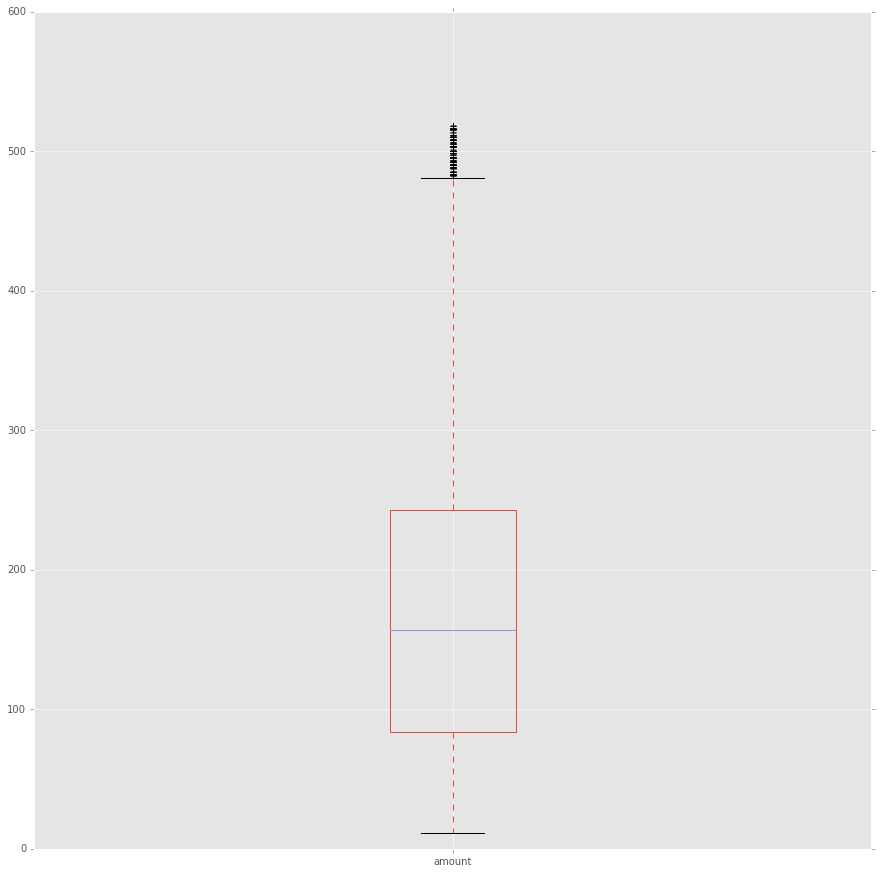

In [69]:
box = plt.figure(figsize=(15,15))
df_20to30.amount.plot(kind='box')
#df_20to30.income.plot(kind='box')